## Setup
The latest versions should be used! And further setup will depend on the necessary tasks.

## Ensemble Learning and Random Forests

- **Wisdom of the crowd**: Aggregating answers from a group can provide better solutions than relying on a single expert.
- **Ensemble learning**: Aggregating predictions from multiple predictors (e.g., classifiers or regressors) often improves accuracy compared to using a single predictor.
  - A group of predictors is called an **ensemble**.
  - The technique is known as **ensemble learning**, and an algorithm using it is called an **ensemble method**.
  
- **Random forests**: 
  - Train a group of decision trees on different random subsets of the training set.
  - Aggregate the predictions from all trees, and the majority vote is the final prediction.
  - Despite its simplicity, random forests are highly powerful machine learning algorithms.

- **Ensemble methods** are often used at the end of a project to combine strong predictors for better results.
  - Many **machine learning competition winners** use ensemble methods, as seen in the Netflix Prize competition.

- **Key ensemble methods** covered in this Notebook:
  - **Voting classifiers**
  - **Bagging and pasting ensembles**
  - **Random forests**
  - **Boosting**
  - **Stacking ensembles**


## Voting Classifiers

- **Voting Classifier**: Combines predictions from multiple classifiers (e.g., logistic regression, SVM, random forest, k-nearest neighbors) and predicts the class with the most votes (majority vote).
  - This is called a **hard voting classifier**.

- **Higher Accuracy**: Hard voting often results in higher accuracy than the best individual classifier in the ensemble.
  - Even weak learners (slightly better than random guessing) can form a strong learner if they are sufficiently diverse and numerous.

- **Analogy**: Similar to tossing a biased coin multiple times—more tosses increase the probability of getting a majority of heads. Similarly, more diverse weak classifiers can improve ensemble accuracy.

- **Independence**: For the best performance, classifiers should be as independent as possible to reduce correlated errors.
  - Training with different algorithms can increase diversity and accuracy.

- **Scikit-Learn**: 
  - Provides a `VotingClassifier` class to easily implement voting classifiers.
  - When using **hard voting**, the classifier predicts based on majority vote.
  - **Soft voting** (averaging class probabilities) can achieve better performance by giving more weight to confident predictions.

- **Soft Voting**: 
  - Requires classifiers to estimate class probabilities using `predict_proba()`.
  - Achieves higher accuracy by considering confidence in predictions.
  - For SVM, enable class probability estimation by setting `probability=True` (slows training but allows soft voting).


In [1]:
# import module
import matplotlib.pyplot as plt
import numpy as np

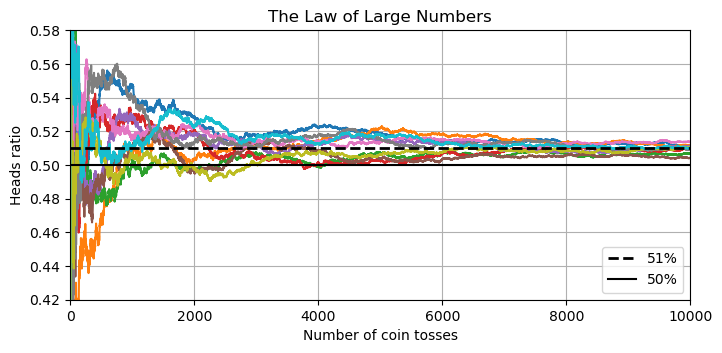

In [3]:
heads_proba = 0.51 # Probability of heads (biased coin with 51% chance of heads)
np.random.seed(42)

# Simulate 10,000 coin tosses for 10 trials (rows: tosses, columns: trials)
# Each toss results in 1 if heads, 0 if tails
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)

# Calculate cumulative sum of heads for each trial
cumulative_heads = coin_tosses.cumsum(axis=0)

# Calculate ratio of heads as tosses increase (rows represent cumulative heads ratio for each toss)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

# Plot the results
plt.figure(figsize=(8, 3.5))  # Set figure size
plt.plot(cumulative_heads_ratio)  # Plot cumulative heads ratio for all trials

# Plot the 51% probability line (expected heads probability)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")

# Plot the 50% line for comparison (fair coin threshold)
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")

# Label the axes
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")

# Add legend in the lower right corner
plt.legend(loc="lower right")

# Set axis limits for clarity ([x_min, x_max, y_min, y_max])
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
plt.title("The Law of Large Numbers")
plt.show()

**Task:** Building a voting classifier

In [4]:
# import necessary modules
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [7]:
# prepare and process the data and train the three models
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [8]:
# each fitted classifier’s accuracy on the test set
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [9]:
# performs hard voting
voting_clf.predict(X_test[:1])

array([1], dtype=int64)

In [11]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64)]

In [12]:
voting_clf.score(X_test, y_test)

0.912

Outcome: The voting classifier outperforms all the individual classifiers.

**Now using soft voting:**
- **Soft Voting**: Soft voting predicts the class with the highest **average class probability** across all classifiers.
  
- **Advantage of Soft Voting**: Soft voting often outperforms hard voting as it gives more weight to predictions with higher confidence levels.

- **Implementation**: 
  - Set the `voting` hyperparameter of **VotingClassifier** to `"soft"` to enable soft voting.
  - Ensure that all classifiers have a `predict_proba()` method to estimate class probabilities.

- **SVC Class Special Case**:
  - The **SVC** classifier does not provide the `predict_proba()` method by default.
  - To enable it, set the `probability=True` hyperparameter, which allows SVC to estimate probabilities.


In [13]:
# enabiling soft voting, train, and calculate the model's performance
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

## Bagging and Pasting

- **Diverse Classifiers**: 
  - You can create diversity by using different training algorithms or by training the same algorithm on random subsets of the training set.

- **Bagging vs. Pasting**:
  - **Bagging** (Bootstrap Aggregating): Sampling **with replacement** from the training set. The same instance can be used multiple times for the same predictor.
  - **Pasting**: Sampling **without replacement** from the training set. Each instance is used only once per predictor.

- **Ensemble Predictions**:
  - After training predictors on different subsets, the ensemble makes predictions by **aggregating** individual predictions.
  - For classification, the most common prediction (mode) is used, similar to hard voting. 
  - For regression, the average prediction is used.

- **Bias and Variance**:
  - Individual predictors have higher **bias** due to training on subsets, but aggregation reduces **both bias and variance**, resulting in lower variance overall compared to a single predictor trained on the full dataset.

- **Parallelization**: 
  - Bagging and pasting can be efficiently parallelized, allowing predictors to be trained and make predictions independently across multiple CPU cores or servers, making these methods scalable and popular.
  


## Bagging and Pasting with Scikit-Learn

- **Scikit-Learn API**: 
  - Use the `BaggingClassifier` (or `BaggingRegressor` for regression) to implement both **bagging** and **pasting**.
  - Example: Training an ensemble of 500 decision tree classifiers with **bagging** by randomly sampling 100 instances with replacement from the training set. 
  - To use **pasting** instead, set `bootstrap=False`.

- **Parallelization**:
  - The `n_jobs` parameter controls the number of CPU cores used. Setting it to `-1` utilizes all available cores for faster training and predictions.

- **Soft Voting**:
  - If the base classifier (e.g., decision trees) has the `predict_proba()` method, the ensemble performs **soft voting** automatically.

- **Ensemble vs. Single Classifier**:
  - Ensembles, like bagging with 500 trees, often **generalize better** than single models by reducing variance, while maintaining similar bias.
  - Decision boundaries of an ensemble are typically smoother and less irregular compared to a single tree.

- **Bias-Variance Tradeoff**:
  - **Bagging** introduces more diversity in the training subsets, slightly increasing bias but reducing variance due to lower correlation between predictors.
  - **Bagging** often leads to better overall performance compared to pasting.

- **Model Selection**:
  - Cross-validation can be used to evaluate both bagging and pasting, and select the best approach based on performance.


In [27]:
# import necessary modules, make the model pipeline, and train the model
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

In [28]:
# train one single decision tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [38]:
# defing function to plot the decision boundary
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

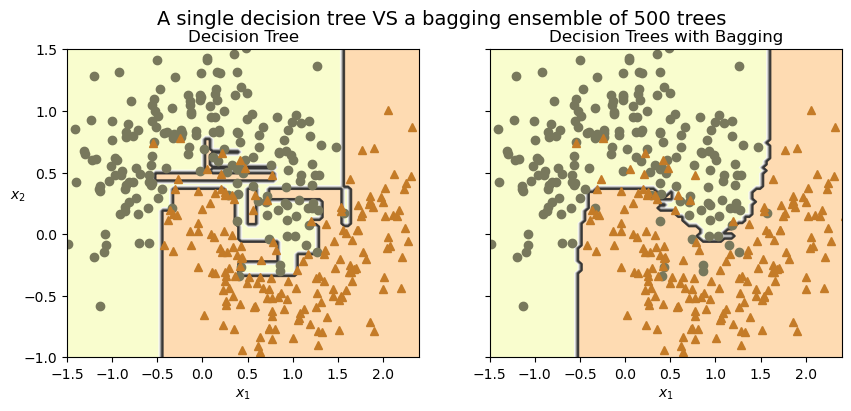

In [39]:
# plotting the differences

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
fig.suptitle("A single decision tree VS a bagging ensemble of 500 trees", fontsize = 14)
plt.show()

### Main Points on Out-of-Bag (OOB) Evaluation:

1. **Sampling in Bagging**:
   - In bagging, each predictor is trained on random subsets of the training set, sampled with replacement. 
   - About 63% of the training instances are used per predictor, leaving around 37% as out-of-bag (OOB) instances.

2. **Out-of-Bag (OOB) Instances**:
   - OOB instances are those not sampled for a given predictor. They vary across predictors.
   - These instances can be used to evaluate the model without needing a separate validation set.

3. **OOB Evaluation**:
   - The model can make predictions on OOB instances, and if there are enough estimators, every training instance will likely be an OOB instance for several predictors.
   - This allows for a reliable ensemble prediction and overall accuracy computation without splitting the dataset.

4. **Scikit-Learn Implementation**:
   - Scikit-Learn’s `BaggingClassifier` has an `oob_score=True` option, enabling automatic OOB evaluation during training.
   - The resulting OOB accuracy can be accessed using the `oob_score_` attribute.


In [40]:
# setting OOB score and calculate it
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [41]:
# probabilities of first 3 instances in being class 0 and 1
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [42]:
# calculating the accuracy

from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

**IDEA:**
- Each instance in a dataset of size *m* has a 1/*m* chance of being picked during sampling.
- When sampling *m* instances with replacement, each instance has a probability of (1 – 1/*m*)ⁿ of not being picked.
- Using the mathematical approximation exp(-1) ≈ 0.37, about 37% of instances will not be picked, meaning roughly 63% will be sampled. In follow:

```python
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))


# Random Forests
### Main Points:
- A **random forest** is an ensemble of decision trees, usually trained using the **bagging** method (or sometimes pasting).
- Instead of manually combining a `BaggingClassifier` with a `DecisionTreeClassifier`, you can use the optimized `RandomForestClassifier` class.
- For regression tasks, `RandomForestRegressor` is available.
- The `RandomForestClassifier` is more convenient and efficient for decision trees.
- Example: Training a random forest with 500 trees, each limited to a maximum of 16 leaf nodes, using all CPU cores.

In [44]:
# import the module, train it, and make prediction
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [45]:
print(y_pred_rf)

[0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0
 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1
 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 1
 0 0 1 1 0 0 0 0 1 1 1 0 0 0]


**Note:** A Random Forest is a bag of decision trees!

In [46]:
# making random forest
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
                            n_estimators=500, n_jobs=-1, random_state=42)

In [47]:
# train and make prediction
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)

In [49]:
print(y_pred_bag)

[0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0
 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1
 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 1
 0 0 1 1 0 0 0 0 1 1 1 0 0 0]


In [48]:
# verifies that the predictions are identical
np.all(y_pred_bag == y_pred_rf)  # same predictions

True

## Feature Importance
### Main Points:
- **Random forests** make it easy to measure the **importance of features**, perform feature selection.
- Scikit-Learn computes feature importance based on how much tree nodes using a feature **reduce impurity** across all trees.
- The importance score is a **weighted average**, with node weights proportional to the number of training samples associated with the node.
- After training, Scikit-Learn automatically computes the importance scores, which sum to **1**.
- The `feature_importances_` attribute provides the importance values for each feature.
- Example: For the **iris dataset**, petal length (44%) and width (42%) are more important than sepal length (11%) and width (2%).


In [50]:
# import data, define model, train it, and calculate importance of features
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


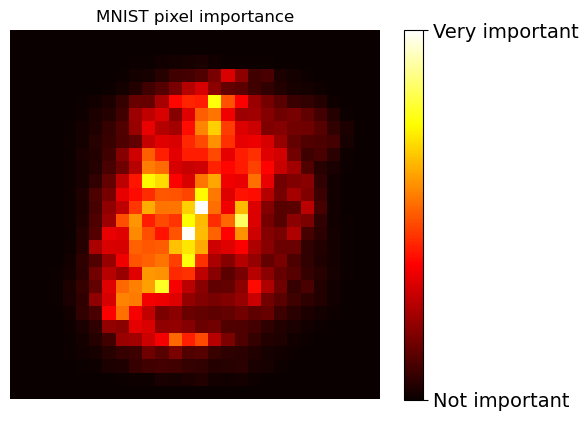

In [51]:
# plot MNIST pixel importance (according to a random forest classifier)

from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False, parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
plt.title("MNIST pixel importance")
plt.show()

# Boosting
### Main Points:
- **Boosting** is an ensemble method that combines multiple **weak learners** into a **strong learner**.
- The key idea in boosting is to train predictors **sequentially**, where each one aims to **correct** the mistakes of its predecessor.
- There are various boosting methods, but the most popular ones are **AdaBoost** (Adaptive Boosting) and **Gradient Boosting**.
- Boosting methods are effective for improving the performance of weak models over time.


## AdaBoost
### Main Points: 

- **AdaBoost** is a boosting method that focuses on misclassified instances by increasing their weights so that new predictors focus on correcting the errors of previous ones.
- It sequentially trains weak learners (e.g., decision trees), updating the instance weights after each round of training, emphasizing harder-to-classify examples.
- AdaBoost assigns different weights to each predictor based on their accuracy, where more accurate predictors receive higher weights.
- Training in **AdaBoost** is **not parallelizable**, as each predictor depends on the previous one, limiting scalability.
- The **AdaBoost algorithm** starts by assigning equal weights to all instances, adjusts the predictor’s weight based on its error rate, and updates instance weights for subsequent predictors.
- **Scikit-Learn's AdaBoostClassifier** uses decision stumps (trees with `max_depth=1`) by default. AdaBoost can handle multiclass problems via **SAMME** or **SAMME.R** (if class probabilities are available).
- To prevent overfitting, consider reducing the number of estimators or regularizing the base learner more strongly.


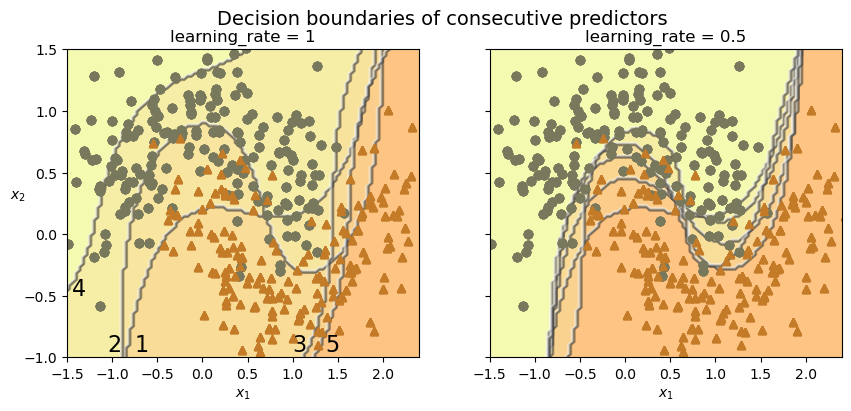

In [53]:
"""This figure displays the decision boundaries of five consecutive predictors 
   trained using an AdaBoost-style algorithm with two different learning rates 
   (1 and 0.5). Each subplot shows how the decision boundary evolves as the model 
   focuses on the harder-to-classify instances, with increasing emphasis on 
   misclassified data after each iteration.
"""
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation
        alpha = learning_rate * np.log((1 - r) / r)  # equation
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

fig.suptitle("Decision boundaries of consecutive predictors", fontsize = 14)
plt.show()

In [54]:
# import and define the model, then train it by using training set
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=30,learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

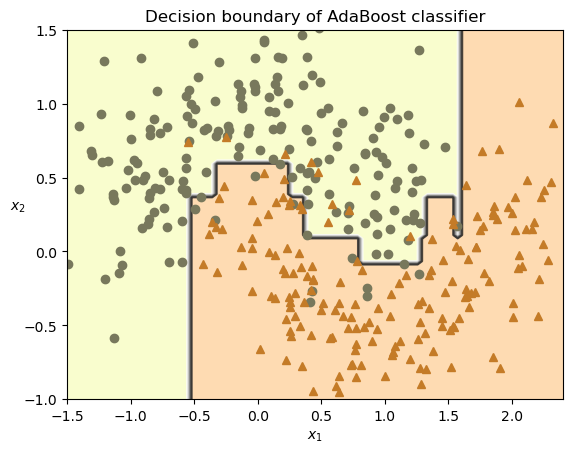

In [57]:
# decision boundary of AdaBoost classifier
plot_decision_boundary(ada_clf, X_train, y_train)
plt.title("Decision boundary of AdaBoost classifier")
plt.show()

## Gradient Boosting
- **Gradient Boosting** is another popular boosting algorithm.
- It sequentially adds predictors, each correcting the errors of its predecessor, similar to AdaBoost.
- Instead of adjusting instance weights, gradient boosting fits new predictors to the residual errors made by previous predictors.
- It is often used with decision trees, known as Gradient Boosted Regression Trees (GBRT) for regression tasks.
- **Example**: 
  - Train the first decision tree on the original data.
  - Train the second tree on the residual errors of the first.
  - Train additional trees on the residuals of the preceding trees.


**Task:** create a simple quadratic dataset and fit a `DecisionTreeRegressor`

In [58]:
# import modules, generating data, define the model, and train it
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

**Task:** train another decision tree regressor on the residual errors made by the previous predictor

In [59]:
# calculating the residual error of the previous model, define a new model, and train the model with the residual error
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [60]:
# calculating the residual error of the previous model, define a new model again, and train the model with the residual error
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [61]:
"""Now we have an ensemble containing three trees.
   It can make predictions on a new instance,
   simply by adding up the predictions of all the trees
"""
X_new = np.array([[-0.4], [0.], [0.5]]) # data points for predicion
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

**NOTE:** In this depiction of gradient boosting, the first predictor (top left) is trained normally, then each consecutive predictor (middle left and lower left) is trained on the previous predictor’s residuals; the right column shows the resulting ensemble’s predictions

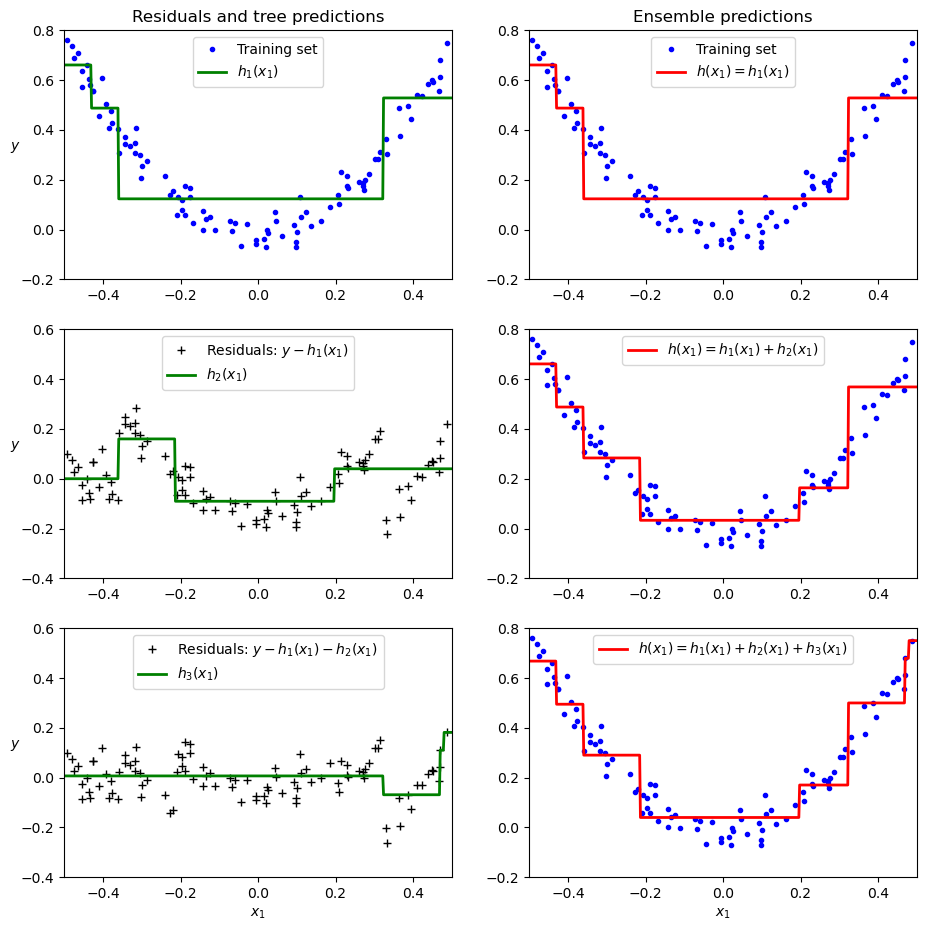

In [67]:
# plot Gradient boosting
def plot_predictions(regressors, X, y, axes, style, label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

# Plot for tree_reg1
plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", rotation=0)
plt.title("Residuals and tree predictions")

# Plot for tree_reg1 ensemble
plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

# Plot for tree_reg2
plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+", data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$", rotation=0)

# Plot for combined tree_reg1 and tree_reg2
plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

# Plot for tree_reg3
plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+", data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

# Plot for combined tree_reg1, tree_reg2, and tree_reg3
plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

plt.show()


**Task:** Try a gradient boosting regressor

In [68]:
# importing, define, and fit the model
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [69]:
# define another model, and train it
gbrt_best = GradientBoostingRegressor(max_depth=2, learning_rate=0.05, n_estimators=500, n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [70]:
gbrt_best.n_estimators_

92

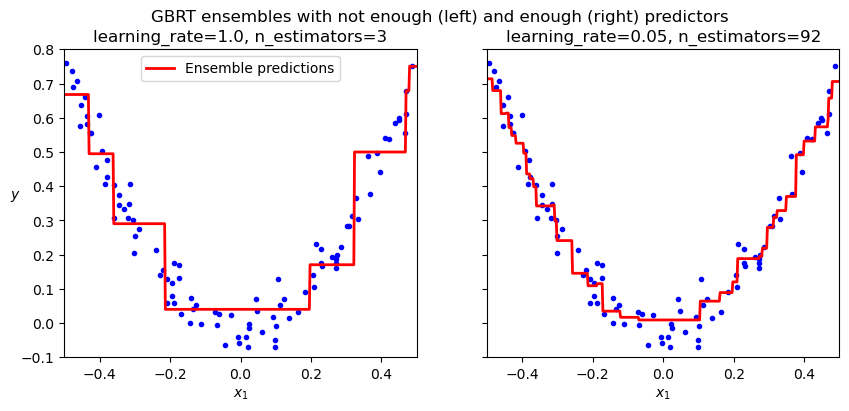

In [72]:
# plot the learning rate

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")
fig.suptitle("GBRT ensembles with not enough (left) and enough (right) predictors", fontsize=12)
plt.show()

### Histogram-Based Gradient Boosting

- **Overview**: Histogram-based gradient boosting (HGB) is an optimized gradient boosting method designed for large datasets.

- **Mechanism**:
  - **Binning**: Features are binned into integers, controlled by the `max_bins` parameter (default: 255).
  - **Efficiency**: Reduces the number of thresholds to evaluate and uses faster, more memory-efficient data structures.
  - **Complexity**: Operates with O(b×m) complexity compared to O(n×m×log(m)) for standard GBRT, where `b` is the number of bins, `m` is the number of training instances, and `n` is the number of features.

- **Performance**:
  - **Speed**: Can be hundreds of times faster than regular GBRT on large datasets.
  - **Precision vs. Regularization**: Binning introduces precision loss, which can act as a regularizer, potentially reducing overfitting or causing underfitting.

- **Scikit-Learn Classes**:
  - **Regressor**: `HistGradientBoostingRegressor`
  - **Classifier**: `HistGradientBoostingClassifier`
  - **Differences from GBRT**:
    - **Early Stopping**: Automatically activated for datasets with more than 10,000 instances. Controlled by `early_stopping`.
    - **Subsampling**: Not supported.
    - **`n_estimators`**: Renamed to `max_iter`.
    - **Decision Tree Hyperparameters**: Limited to `max_leaf_nodes`, `min_samples_leaf`, and `max_depth`.
  - **Features**:
    - Supports categorical features and missing values.
    - Categorical features must be encoded as integers from 0 to `max_bins - 1`.

- **Pipeline Example**:
  - Simplifies preprocessing by handling categorical features and missing values, eliminating the need for additional preprocessing steps like imputation or scaling.

- **Additional Tools**:
  - **Other Libraries**: Consider XGBoost, CatBoost, and LightGBM for specialized gradient boosting implementations with features like GPU acceleration.
  - **TensorFlow Random Forests**: Provides optimized implementations of various random forest algorithms, including GBRT.


## Stacking


- **Concept**: Stacking, or stacked generalization, aggregates predictions from multiple models using a meta-model (or "blender") rather than simple aggregation methods like hard voting.
  
- **How It Works**:
  - **Ensemble Predictions**: Base predictors provide predictions for a given instance.
  - **Blender**: A meta-model takes these predictions as inputs and produces the final prediction.
  
- **Training the Blender**:
  - **Blending Training Set**: Use `cross_val_predict()` on base predictors to generate out-of-sample predictions, which become input features for the blender. The targets are copied from the original training set.
  - **Retrain**: After training the blender, retrain the base predictors on the full original training set.

- **Advanced Stacking**:
  - **Multiple Layers**: You can train several different blenders (e.g., linear regression, random forest) and stack them in layers to potentially improve performance. This adds complexity and training time.
  
- **Scikit-Learn Classes**:
  - **`StackingClassifier`**: Aggregates predictions using a meta-model. Defaults to `LogisticRegression` if no final estimator is provided.
  - **`StackingRegressor`**: Similar to `StackingClassifier` but for regression tasks.

- **Example**:
  - **VotingClassifier vs. StackingClassifier**: On the moons dataset, a `StackingClassifier` achieved 92.8% accuracy, outperforming a voting classifier with 92% accuracy.

- **Conclusion**:
  - **Versatility**: Ensemble methods like random forests, AdaBoost, and GBRT are powerful and require minimal preprocessing, making them great for quick prototyping.
  - **Performance**: Techniques like stacking can push model performance to higher levels.


In [75]:
# importing, define, and train the model

from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [78]:
# calculating score of the trained model on test dataset
print("The score of the model is: {}".format(stacking_clf.score(X_test, y_test)))

The score of the model is: 0.928


**Checkout:** Most important concepts are here explained, can be used in different cases if needed! Thank You!